In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

## Mountain Car using episodic, semi-gradient, n-step SARSA with tiling approximation

In [2]:
class CarEnv:
  def __init__(self, x_low=-1.2, x_high=0.5, v_low=-0.07, v_high=0.07):
    self.x_low = x_low
    self.x_high = x_high
    self.v_low = v_low
    self.v_high = v_high

  def reset(self):
    return (np.random.random()/5)-0.6, 0

  def step(self, x, v, a):
    vp = self.bound_v(v + 0.001*(a-1) - 0.0025*np.cos(3*x))
    xp = self.bound_x(x + vp)
    r = -1
    return r, xp, vp, xp>=self.x_high

  def bound_x(self, x):
    if x < self.x_low:
      return self.x_low
    elif x > self.x_high:
      return self.x_high
    else:
      return x
  
  def bound_v(self, v):
    if v < self.v_low:
      return self.v_low
    elif v > self.v_high:
      return self.v_high
    else:
      return v

  def get_bounds(self):
    return (self.x_low, self.x_high, self.v_low, self.v_high)

In [35]:
class CarSystem:
  def __init__(self, env, alpha=0.1, eps=0.01, gamma=1, n=4, episodes=100, tilings=(2,8,8)):
    self.env = env
    self.alpha = alpha
    self.eps = eps
    self.gamma = gamma
    self.n = n
    self.tilings = tilings # number of tilings, tiles along dimension 1, tiles along dimension 2

    self.bounds = env.get_bounds()
    self.x_width = (self.bounds[1] - self.bounds[0])/self.tilings[1]
    self.v_width = (self.bounds[3] - self.bounds[2])/self.tilings[2]
    self.time_list = []
    self.episodes = episodes

    self.w = np.zeros((self.tilings[0], self.tilings[1]+1, self.tilings[2]+1, 3))
    # Before:
    # q(s) is the value at (x,v)
    # q(s,w) is the value at tile(x,v), where w represents the values at each tile
    #        i.e. q(s,w) is the value at state (e.g. position and velocity) x,v, using the tile approximation provided by w
    # q(s,a,w) is the value of taking action a at tile(x,v). Now, w represents the values at each tile-action pair
    #        i.e. q(s,a,w) is the value at state x,v,a, using the tile-action approximation provided by w

    # Later:
    # In general, w is the values obtained from function approximation. In this case, our function is a step function, which
    #        holds a constant value within a range, for multiple ranges.
    # w is a vector (n-D) of all the value estimates.
    # Then the w update is modifying all components of w (all value estimates) in a single update that is based on the function 
    #        approximated value at the current state. In the case of tiling approximation, the update to 1 tile doesn't affect
    #        any other tiles. This can be reasoned in the gradient as well: Updating any tile by some amount will update any
    #        other tile by 0, so the gradient of the value update w.r.t to the other tile is 0. Updating the same tile by some
    #        amount updates that same tile tile by the same amount. Thus, the gradient for the same tile is 1, because the changes
    #        are 1:1. This makes grad(v(s,w)) or grad(q(s,a,w)) into indicator functions for tiling approximations. As a result,
    #        the w update limits changes to just 1 component.

    # But wait, earlier we saw that q(s,a,w) = w.T * x(s,a), where x(s,a) is a feature vector for s,a. A feature vector consists
    #        of the different dimensions of data we want to consider for value estimates. In this case, each tiling is a separate
    #        feature. The number of tilings is the dimensionality of the features. These features are used for value estimation.
    #        Thinking in terms of linear regression, x(s,a) is like beta, where it has a value (coefficient) for each feature. And
    #        w is the value at each of these features. So the value for each of the tilings, under the conditions of using the 
    #        specific tile chosen for each tiling (each dimension). The formula we're given is exactly that. It's a linear
    #        approximation of the value, because it uses a linear combination of features which are obtained from distinct tiles.
    # How has this changed our interpretation of q from earlier? Somewhat. Now we know that q is not necessarily some pre-defined
    #        shape. In fact, in terms of the algorithm, we don't initialize q to anything at all. q is a byproduct of the weights
    #        w and the features x(s,a). It is calculated on every round. There is a distinct q-value for each s-a pair, where s-a refers
    #        to (x,v)-a. Since there are actually infinite possibilities for s-a pairs, there's no way to store or initialize q to
    #        some shape. However, there is an inherent shape since it's calculated using the discrete spaces of w and x(s,a). It's not
    #        the same shape as w, because it is based on the positions of x,v and not the mappings of tile(x,v)

    # Correction: Each tile-action in w is a value estimate for a feature. So for (2x8x8x3), there are 384 features. At any time, 
    #        most of these features will be 0. The chosen ones will be 1. The values in w are like the coefficients for the features.
    #        Think of it like beta in linear regression. w is to beta, as x(s,a) is to X.
    #        Both w and beta have coefficients (weights) for the actual feature values.
    #        The actual feature values are in x(s,a) and X. For x(s,a), the values can be 0 or 1.
  def run(self):
    for episode in tqdm.tqdm(range(self.episodes)):
      t = 0
      tau = 0
      T = 100000

      x, v = self.env.reset()
      done = False

      q_sw = self.q(x, v)
      a = np.argmax(q_sw) if np.random.random() > self.eps else np.random.choice([0,1,2])
      
      x_list = [x]
      v_list = [v]
      a_list = [a]
      r_list = []

      while not done:
        if t < T:
          x = x_list[-1]
          v = v_list[-1]
          a = a_list[-1]
          
          r, xp, vp, done = self.env.step(x, v, a)
          r_list.append(r)

          if done:
            T = t + 1
          else:
            q_spw = self.q(xp, vp)
            ap = np.argmax(q_spw) if np.random.random() > self.eps else np.random.choice([0,1,2])

            x_list.append(xp)
            v_list.append(vp)
            a_list.append(ap)
        
        tau = t - self.n + 1

        if tau >= 0:
          G = np.sum([(self.gamma**i)*r_list[i] for i in range(len(r_list))])
          if tau + self.n < T:
            G += (self.gamma**self.n) * self.q(x_list[-1], v_list[-1], a_list[-1])
          grad_q = np.zeros(self.w.shape)
          grad_q[tuple(self.f(x_list[0], v_list[0], a_list[0]).T)] = 1
          self.w += self.alpha * (G - self.q(x_list[0], v_list[0], a_list[0])) * grad_q

          x_list.pop(0)
          v_list.pop(0)
          a_list.pop(0)
          r_list.pop(0)

        t += 1
      self.time_list.append(t)

  def q(self, x, v, a=None):
    if a == None:
      tiles = self.f(x, v)
      return np.sum(self.w[tuple(tiles.T)], axis=0)
    else:
      tile_actions = self.f(x, v, a)
      return np.sum(self.w[tuple(tile_actions.T)])

  def f(self, x, v, a=None):
    if a == None:
      tiles = [[i, int((x-self.bounds[0]+self.x_width*i/self.tilings[0])/self.x_width), int((v-self.bounds[2]+self.v_width*i/self.tilings[0])/self.v_width)] for i in range(self.tilings[0])]
      return np.array(tiles)
    else: 
      tile_actions = [[i, int((x-self.bounds[0]+self.x_width*i/self.tilings[0])/self.x_width), int((v-self.bounds[2]+self.v_width*i/self.tilings[0])/self.v_width), a] for i in range(self.tilings[0])]
      return np.array(tile_actions)

  def get_time_list(self):
    return self.time_list

In [40]:
sys1 = CarSystem(CarEnv(), n=1, tilings=(1,8,8))
sys1.run()
sys2 = CarSystem(CarEnv(), n=1, tilings=(4,8,8))
sys2.run()
sys3 = CarSystem(CarEnv(), n=4, tilings=(1,8,8))
sys3.run()
sys4 = CarSystem(CarEnv(), n=4, tilings=(4,8,8))
sys4.run()

100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


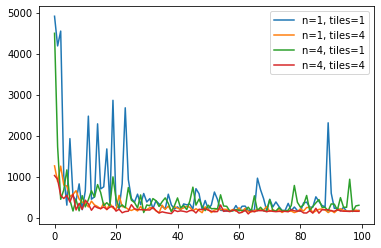

In [41]:
plt.plot(sys1.get_time_list(), label="n=1, tiles=1")
plt.plot(sys2.get_time_list(), label="n=1, tiles=4")
plt.plot(sys3.get_time_list(), label="n=4, tiles=1")
plt.plot(sys4.get_time_list(), label="n=4, tiles=4")
plt.legend()

## Access Control using differential, semi-gradient, n-step SARSA with tabular method

In [169]:
class ServerEnv:
  def __init__(self, servers=10, priorities=[1,2,4,8], p=0.06):
    self.servers = servers
    self.priorities = priorities
    self.p = p

    self.servers_free = self.servers

  def reset(self):
    return self.servers, np.random.choice(np.arange(len(self.priorities)))

  def step(self, s, a): # s: (servers free, priority)
    empty = self.servers_free <= 0

    self.servers_free -= 1 if a==1 and not empty else 0

    # free busy servers
    for i in range(self.servers-self.servers_free):
      if np.random.random() < self.p:
        self.servers_free += 1
    
    return self.priorities[s[1]] if a==1 and not empty else 0, (self.servers_free, np.random.choice(np.arange(len(self.priorities))))

  def get_specs(self):
    return self.servers, self.priorities

class ServerAgent:
  def __init__(self, servers=10, priorities=[1,2,4,8], eps=0.1, alpha=0.01, beta=0.01):
    self.servers = servers
    self.priorities = priorities
    self.eps = eps
    self.alpha = alpha
    self.beta = beta

    self.w = np.zeros((self.servers+1, len(self.priorities), 2))
    self.r_bar = 0

  def action(self, s):
    if s[0] == 0:
      return 0
    a = np.argmax(self.q(s)) if np.random.random() > self.eps else np.random.choice([0,1])
    return a

  def update(self, s, a, r, sp, ap):
    delta = np.sum(np.array(r)-self.r_bar) + self.q(sp, ap) - self.q(s, a)
    self.r_bar += self.beta * delta
    self.w += self.alpha * delta * self.grad_q(s, a)

  def q(self, state, action=None):
    if action == None:
      return self.w[state[0], state[1]]
    else: 
      return self.w[state[0], state[1], action]

  def grad_q(self, state, action):
    dq = np.zeros((self.servers+1, len(self.priorities), 2))
    dq[state[0], state[1], action] = 1
    return dq

  def get_w(self):
    return self.w

In [172]:
class ServerSystem:
  def __init__(self, env, alpha=0.01, beta=0.01, eps=0.1, n=4, max_steps=100):
    self.env = env
    self.servers, self.priorities = env.get_specs()
    self.n = n
    self.max_steps = max_steps

    self.agent = ServerAgent(servers=self.servers, priorities=self.priorities, eps=eps, alpha=alpha, beta=beta)

  def run(self):
    s_list = [self.env.reset()]
    a_list = [self.agent.action(s_list[-1])]
    r_list = []

    for t in tqdm.tqdm(range(self.max_steps)):
      s = s_list[-1]
      a = a_list[-1]
      r, sp = self.env.step(s, a)
      ap = self.agent.action(sp)
      s_list.append(sp)
      a_list.append(ap)
      r_list.append(r)

      tau = t - self.n + 1

      if tau >=0:
        self.agent.update(s_list[0], a_list[0], r_list, s_list[-1], a_list[-1])

        s_list.pop(0)
        a_list.pop(0)
        r_list.pop(0)

      t += 1
  
  def get_weights(self):
    return self.agent.get_w()

In [175]:
ss1 = ServerSystem(ServerEnv(), max_steps=10000)
ss1.run()

100%|██████████| 10000/10000 [00:00<00:00, 16942.23it/s]


In [176]:
np.argmax(ss1.get_weights(), axis=2).T[:,1:]

array([[0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])